In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from fully_observed_models import MixtureOfTwoGaussians, SumOfTwoUnnormalisedGaussians2
from latent_variable_model import LatentMixtureOfTwoUnnormalisedGaussians2
from nce_optimiser import NCEOptimiser
from mle_optimiser import MLEOptimiser
from utils import evaluate_loss_at_param
from vnce_optimiser import VemOptimiser, ScipyMinimiseEmStep, ExactEStep, VnceLossWithAnalyticExpectations

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)
save_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/experiments/mog/unnormalised_variationalem'
os.makedirs(save_dir, exist_ok=True)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 1
sigma0 = 4  # (parameter of interest)

n = 10000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE
c0 = np.log(2) + 0.5*np.log(2*np.pi) + np.log(sigma0)   # true value of 1st scaling parameter
c1 = np.log(2) + 0.5*np.log(2*np.pi) + np.log(sigma1)   # true value of 2nd scaling parameter

true_theta = np.array([c0, c1, np.log(sigma0)])
true_alpha = np.array([c1 - c0, 0, (1 / (2*sigma1**2)) - (1 / (2*sigma0**2))])

theta0 = np.array([0, 0.1, 1])  # initial theta
# theta0 = true_theta
alpha0 = np.array([0, -0.1, 0.1]) # initial alpha

In [5]:
# true dist is 0.5*N(u; 0, sigma0) + 0.5*N(u; 0, sigma1)
true_data_dist = MixtureOfTwoGaussians(theta=np.log(sigma0), sigma1=sigma1, rng=rng)
X = true_data_dist.sample(n) # generate data

In [6]:
noise = GaussianNoise(mean=0, cov=sigma0**2)
Y = noise.sample(int(n*nu))

In [7]:
model = LatentMixtureOfTwoUnnormalisedGaussians2(theta0, sigma1=sigma1)
nce_model = SumOfTwoUnnormalisedGaussians2(theta0, sigma1=sigma1)  # for comparison
# mle_model = SumOfTwoNormalisedGaussians(np.array([0]), sigma1 = sigma1)  # for comparison

In [8]:
var_dist = PolynomialSigmoidBernoulli(alpha=alpha0)

In [9]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [19]:
nce_optimiser = NCEOptimiser(model=nce_model, noise=noise, noise_samples=Y, nu=nu, eps=10**-20)
# mle_optimiser = MLEOptimiser(model=mle_model)

In [20]:
loss_function = VnceLossWithAnalyticExpectations(model=model,
                                                 data=X,
                                                 noise=noise,
                                                 noise_samples=Y,
                                                 variational_noise=var_dist,
                                                 E1=E1, 
                                                 E2=E2, 
                                                 E3=E3, 
                                                 E4=E4, 
                                                 E5=E5,
                                                 noise_to_data_ratio=nu)
m_step = ScipyMinimiseEmStep(do_m_step=True, optimisation_method='BFGS')  # Nelder-Mead
e_step = ScipyMinimiseEmStep(do_m_step=False, optimisation_method='BFGS')
optimiser = VemOptimiser(m_step=m_step, e_step=e_step)

In [21]:
optimiser.fit(loss_function=loss_function, theta0=theta0, alpha0=alpha0, stop_threshold=1e-5)

         Current function value: 1.426608
         Iterations: 12
         Function evaluations: 76
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 1.291137
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.288876
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.288346
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.287919
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.287576
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization

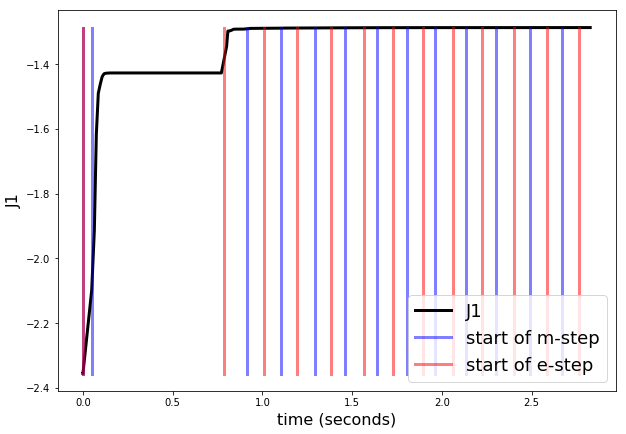

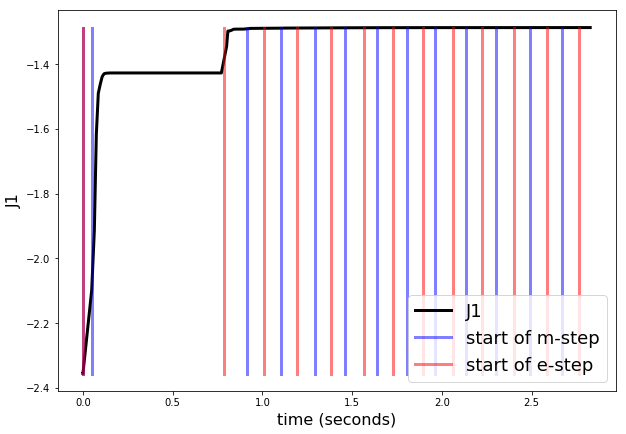

In [22]:
optimiser.plot_loss_curve()

In [23]:
_ = nce_optimiser.fit(X, theta0=theta0, opt_method='L-BFGS-B')

In [24]:
print('vnce parameter estimates are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(optimiser.thetas[-1][-1][0], 
                                      optimiser.thetas[-1][-1][1],
                                      optimiser.thetas[-1][-1][2]))

vnce parameter estimates are: 
scaling parameter 1: 2.9838820278436877 
scaling parameter 2: 1.6316061105811306 
standard deviation: 1.3755101860420214


In [25]:
print('nce parameter estimates are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(nce_model.theta[0], 
                                      nce_model.theta[1], 
                                      nce_model.theta[2]))

nce parameter estimates are: 
scaling parameter 1: 2.995036330243762 
scaling parameter 2: 1.6207011077211884 
standard deviation: 1.3788768973751884


In [26]:
print('True parameters are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(true_theta[0], true_theta[1], true_theta[2]))

True parameters are: 
scaling parameter 1: 2.9983800748845084 
scaling parameter 2: 1.612085713764618 
standard deviation: 1.3862943611198906
